## Initial Setup


In [87]:
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn import svm
from sklearn.svm import SVR
from sklearn import metrics

from tensorflow.keras import backend as K

from scipy import stats
from datetime import datetime

mpl.rcParams['figure.figsize'] = (12, 9)
mpl.rcParams['axes.grid'] = False

Variables which will be necessary later for the Recurrent Neural Network are initialized

In [88]:
TRAIN_SPLIT = 6400
tf.random.set_random_seed(13)
BATCH_SIZE = 256
BUFFER_SIZE = 10000
STEP = 1

# Data Prep

The CSV files are imported into Pandas DataFrames

In [89]:
tempUrl = 'https://raw.githubusercontent.com/buds-lab/the-building-data-genome-project/master/data/raw/temp_open_utc.csv'
tempOpen = pd.read_csv(tempUrl)

In [90]:
dfTemp = pd.DataFrame()

metaUrl = 'https://raw.githubusercontent.com/buds-lab/the-building-data-genome-project/master/data/raw/meta_open.csv'
metaOpen = pd.read_csv(metaUrl)

These functions return the hour or day of the year based on the date inputted

In [91]:
def getHour(dayx):
    return dayx.hour

def getDayOfYear(dayy):
    return dayy.timetuple().tm_yday

The getWeather functions gathers weather data from the repository for the building, cleans it and prepares it to be merged

In [92]:
def getWeather(weatherNo):
    # Weather columns:
    #timestamp	Conditions	DateUTC<br />	Dew PointC	Events	Gust SpeedKm/h	Humidity	
    #Precipitationmm	Sea Level PressurehPa	TemperatureC	TimeBST	TimeGMT	VisibilityKm	Wind Direction	Wind SpeedKm/h	WindDirDegrees	timestamp

    weatherUrl = "https://raw.githubusercontent.com/buds-lab/the-building-data-genome-project/master/data/external/weather/" + weatherNo

    weather1x = pd.read_csv(weatherUrl, index_col = 0)
    weather1x = weather1x.rename(columns = {'Wind SpeedKm/h' : "WindSpeedKmh"})

    weather1 = weather1x[['TemperatureC','Humidity','Sea Level PressurehPa', 'Dew PointC', 'VisibilityKm', "WindSpeedKmh"]].copy()

    county = 0
    for y in weather1['WindSpeedKmh']:
        if y == 'Calm':
            weather1.iloc[county,5] = np.NaN
        county += 1

    weather1 = weather1.astype(np.float)


    weather1.index = pd.to_datetime(weather1.index, utc = True)

    # Weather files are resampled to align timestamps with other data
    weather1 = weather1.resample('60min').mean()
    #weather1.to_csv('weather1resampled.csv')

    #Interpolating missing data in the key columns
    weather1['TemperatureC'] = weather1['TemperatureC'].interpolate()
    weather1['Humidity'] = weather1['Humidity'].interpolate()
    weather1['Sea Level PressurehPa'] = weather1['Sea Level PressurehPa'].interpolate()

    weather1['Dew PointC'] = weather1['Dew PointC'].interpolate()
    weather1['VisibilityKm'] = weather1['VisibilityKm'].interpolate()
    weather1['WindSpeedKmh'] = weather1['WindSpeedKmh'].interpolate()



    # Removing outliers and replacing with NaNs to be interpolated
    z = np.abs(stats.zscore(weather1))

    # Outliers, defined as having a zscore gt 5, are replaced with NaNs
    x,y = np.where(z > 5)
    for f in range(x.size):
        weather1.iloc[x[f],y[f]] = np.NaN

    # These are again interpolated
    weather1['TemperatureC'] = weather1['TemperatureC'].interpolate()
    weather1['Humidity'] = weather1['Humidity'].interpolate()
    weather1['Sea Level PressurehPa'] = weather1['Sea Level PressurehPa'].interpolate()

    weather1['Dew PointC'] = weather1['Dew PointC'].interpolate()
    weather1['VisibilityKm'] = weather1['VisibilityKm'].interpolate()
    weather1['WindSpeedKmh'] = weather1['WindSpeedKmh'].interpolate()

    weather1['dayOfTheWeek'] = weather1.index
    weather1['dayOfTheWeek'] = weather1['dayOfTheWeek'].apply(datetime.weekday)

    weather1['hourOfTheDay'] = weather1.index
    weather1['hourOfTheDay'] = weather1['hourOfTheDay'].apply(getHour)

    weather1['dayOfTheYear'] = weather1.index
    weather1['dayOfTheYear'] = weather1['dayOfTheYear'].apply(getDayOfYear)

    weather1['dayOfTheWeek'] = weather1['dayOfTheWeek'].fillna(method = 'ffill')
    weather1['hourOfTheDay'] = weather1['hourOfTheDay'].fillna(method = 'ffill')
    weather1['dayOfTheYear'] = weather1['dayOfTheYear'].fillna(method = 'ffill')

    return weather1

The following creates a dictionary where building names are matched up to a few key pieces of their meta data

In [93]:
columnDict = {}

for index, row in metaOpen.iterrows():
    columnDict[row['uid']] = [row['sqm'],row['newweatherfilename'],row['primaryspaceusage'],row['timezone']]

Finally the files are collated. A counter is used to ensure only 3 buildings are done (for time purposes) but this can be removed to do all buildings. A CSV file containing all relevant building data is created.

In [94]:
counter = 0

for column in tempOpen:
    # Counter used here to stop at 3 buildings, for testing purposes
    if counter == 3:
        break

    if counter != 0 and column != 'timestamp':
        dfTemp['timestamp'] = tempOpen['timestamp']
        dfTemp['Usage'] = (tempOpen[column])
        
        dfTemp['sqm'] = columnDict[column][0]
        dfTemp['newweatherfilename'] = columnDict[column][1]
        dfTemp['primaryspaceusage'] = columnDict[column][2]
        dfTemp['timezone'] = columnDict[column][3]

        newWeatherFile = getWeather(columnDict[column][1])

        dfTemp['timestamp'] = pd.to_datetime(dfTemp['timestamp'])
        mergedTempDf = pd.merge(dfTemp,newWeatherFile, on='timestamp')

        mergedTempDf = mergedTempDf.set_index('timestamp')


        df_interpol = mergedTempDf\
                .resample('H')\
                .mean()
        df_interpol['Usage'] = df_interpol['Usage'].interpolate()
        
        dfx = df_interpol[df_interpol.isna().any(axis=1)]
        
        df_interpol.to_csv(column + '_Interpol.csv')

        dfTemp.drop(['Usage', "timestamp"], axis = 1, inplace = True)

    counter += 1

The data is then put into a DataFrame and normalized. Some of the relevant features are plotted before and after normalization.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C780255748>,
      dtype=object)

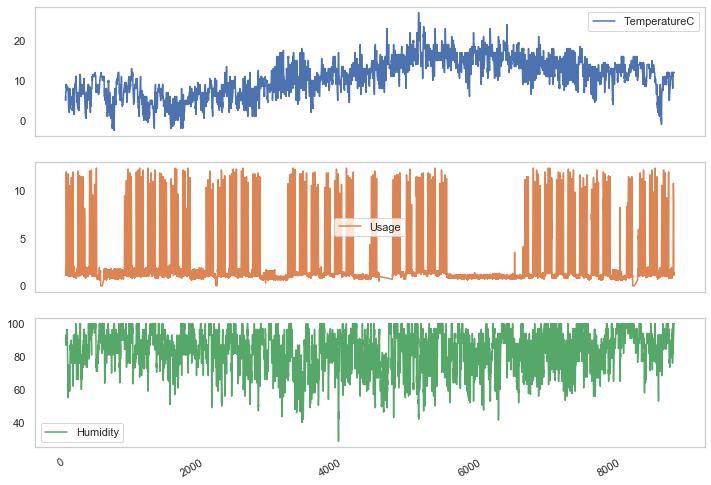

In [95]:
df = pd.read_csv('PrimClass_Jaylin_Interpol.csv')

features_considered = ['TemperatureC','Usage', 'Humidity','Sea Level PressurehPa',
                       'Dew PointC', 'VisibilityKm', "WindSpeedKmh", 'dayOfTheWeek', 'hourOfTheDay']

features = df[features_considered]
features.index = df['timestamp']

dataset1 = np.zeros(shape=(0,0))

dataset1 = features.values
data_mean = np.nanmean(dataset1[:TRAIN_SPLIT],axis=0)
data_std = np.nanstd(dataset1[:TRAIN_SPLIT],axis=0)

dataset1df = pd.DataFrame(dataset1, columns = ['TemperatureC','Usage', 'Humidity','Sea Level PressurehPa',
                       'Dew PointC', 'VisibilityKm', "WindSpeedKmh", 'dayOfTheWeek', 'hourOfTheDay'])

dataset1df[['TemperatureC','Usage', 'Humidity']].plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7FC662608>,
      dtype=object)

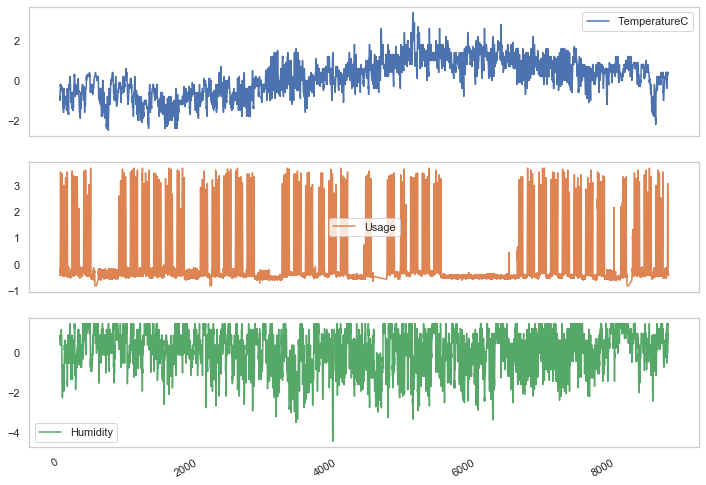

In [96]:
dataset1 = (dataset1-data_mean)/data_std

dataset1df = pd.DataFrame(dataset1, columns = ['TemperatureC','Usage', 'Humidity','Sea Level PressurehPa',
                       'Dew PointC', 'VisibilityKm', "WindSpeedKmh", 'dayOfTheWeek', 'hourOfTheDay'])

usageDataMaster = dataset1df.copy()

dataset1df[['TemperatureC','Usage', 'Humidity']].plot(subplots=True)

Predictions using all features are quite poor so we now perform feature selection, using a pairwise correlation feature.

In [99]:
dataset1df.corr()

,TemperatureC,Usage,Humidity,Sea Level PressurehPa,Dew PointC,VisibilityKm,WindSpeedKmh,dayOfTheWeek,hourOfTheDay
TemperatureC,1.000000,0.004657,-0.270185,-0.111295,0.871795,-0.117973,0.100674,-5.803467e-03,1.471611e-01
Usage,0.004657,1.000000,-0.129895,-0.009954,-0.058925,0.078085,0.089089,-2.147527e-01,-2.619766e-02
Humidity,-0.270185,-0.129895,1.000000,-0.161138,0.232853,0.012513,-0.123916,-7.700328e-03,-2.339061e-01
Sea Level PressurehPa,-0.111295,-0.009954,-0.161138,1.000000,-0.196078,-0.064435,-0.330989,2.256737e-02,1.066694e-02
Dew PointC,0.871795,-0.058925,0.232853,-0.196078,1.000000,-0.106014,0.043016,-7.121962e-03,3.197493e-02
VisibilityKm,-0.117973,0.078085,0.012513,-0.064435,-0.106014,1.000000,0.105762,1.413141e-02,-7.201093e-03
WindSpeedKmh,0.100674,0.089089,-0.123916,-0.330989,0.043016,0.105762,1.000000,-2.305361e-02,5.804520e-02
dayOfTheWeek,-0.005803,-0.214753,-0.007700,0.022567,-0.007122,0.014131,-0.023054,1.000000e+00,-1.520204e-19
hourOfTheDay,0.147161,-0.026198,-0.233906,0.010667,0.031975,-0.007201,0.058045,-1.520204e-19,1.000000e+00


Since we are trying to predict the building metering data (denoted as Usage), we sort the correlations with Usage in descending order.

In [100]:
sortedFeatures = dataset1df.corr()['Usage'].abs().sort_values(ascending = False)
sortedFeatures

Usage                    1.000000
dayOfTheWeek             0.214753
Humidity                 0.129895
WindSpeedKmh             0.089089
VisibilityKm             0.078085
Dew PointC               0.058925
hourOfTheDay             0.026198
Sea Level PressurehPa    0.009954
TemperatureC             0.004657
Name: Usage, dtype: float64

From this table we can see the features which correlate the most with usage (PrimClass_Jaylin) are Humidity, Wind Speed and the day of the week. Therefore we will make a dataset with only these values.

In [101]:
dates = np.arange(0,1568)

In [102]:
usageData = usageDataMaster.copy()

usageData.columns

Index(['TemperatureC', 'Usage', 'Humidity', 'Sea Level PressurehPa',
       'Dew PointC', 'VisibilityKm', 'WindSpeedKmh', 'dayOfTheWeek',
       'hourOfTheDay'],
      dtype='object')

We created a new feature 'Usage24Ahead', which is the Usage data for the time 24 hours after that time stamp

In [103]:
usageData['Usage24Ahead'] = usageData['Usage'].shift(-24)
usageData = usageData.dropna()

usageData.drop(['TemperatureC','Sea Level PressurehPa','Dew PointC', 'VisibilityKm','hourOfTheDay'], axis = 1, inplace = True)

# Support Vector Machine

Next we created the SVM. We must first separate the values into the dependent variables (X_svm) and the independent variable which we are trying to predict (y_svm). We then split this data into training and test data.

In [104]:
X_svm = np.array(usageData[['Usage', 'Humidity','WindSpeedKmh', 'dayOfTheWeek']])
y_svm = np.array(usageData['Usage24Ahead'])

In [105]:
from sklearn.model_selection import train_test_split
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size = 0.2, random_state = 42)

The SVM is predicting 24 hours ahead using 24 hours of past history, with a step of 1 (one hour)

In [106]:
svm_past_history = 24
svm_future_target = 24
svm_STEP = 1

In [107]:
usageData.drop(['Usage24Ahead'], axis = 1, inplace = True)

In [108]:
usageDataArray = np.array(usageData)

In [109]:
def multivariate_data_no_shift(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

The data is segmented into 24 hour windows to allow us to evaluate and visualize predictions

In [110]:
svm_x_train, svm_y_train = multivariate_data_no_shift(usageDataArray[:,0:4], usageDataArray[:, 0], 0,
                                                   TRAIN_SPLIT, svm_past_history,
                                                   svm_future_target, svm_STEP)
svm_x_val, svm_y_val = multivariate_data_no_shift(usageDataArray[:,0:4], usageDataArray[:, 0],
                                               TRAIN_SPLIT, None, svm_past_history,
                                               svm_future_target, svm_STEP)

In [111]:
print ('Single window of past history : {}'.format(svm_x_train[0].shape))

Single window of past history : (24, 4)


In [112]:
train_data_svm = tf.data.Dataset.from_tensor_slices((svm_x_train, svm_y_train))
train_data_svm = train_data_svm.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_svm = tf.data.Dataset.from_tensor_slices((svm_x_val, svm_y_val))
val_data_svm = val_data_svm.batch(BATCH_SIZE).repeat()

The SVM is then fitted

In [113]:
reg_svr = SVR()
reg_svr.fit(X_train_svm, y_train_svm)
y_pred_svm = reg_svr.predict(svm_x_val[1020])

Below is a visualization of one 24 hour period.

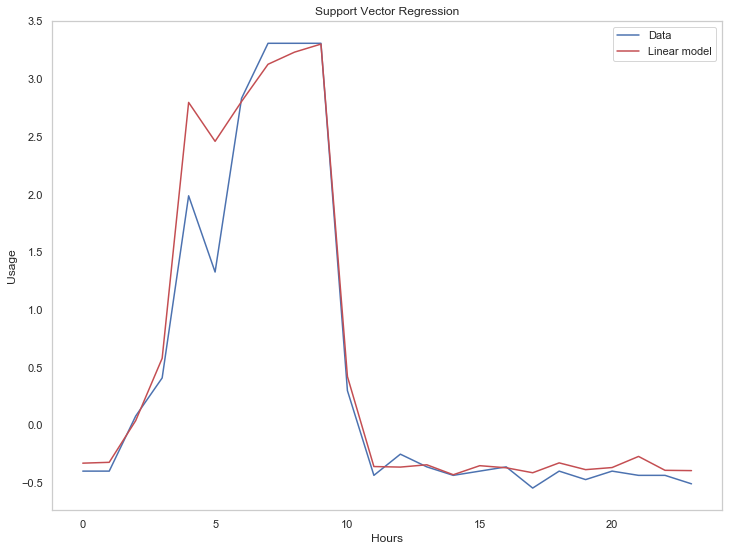

In [114]:
dates = np.arange(0,24)
    
plt.plot(dates, (svm_y_val[1020]), c='b', label='Data')
plt.plot(dates, y_pred_svm, c='r', label='Linear model')
    
plt.xlabel('Hours')
plt.ylabel('Usage')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

We then make a prediction of the entire dataset and plot part of this

In [115]:
full_pred = reg_svr.predict(X_test_svm)

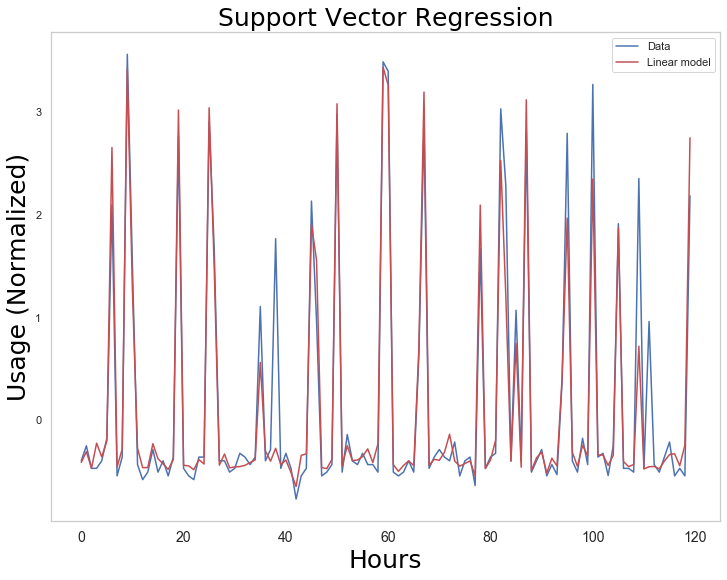

In [116]:
dates = np.arange(0,1748)
  
font = {'family': 'DejaVu Sans',
        'color':  'black',
        'weight': 'normal',
        'size': 25,
        }

plt.plot(dates[:120], y_test_svm[:120], c='b', label='Data')
plt.plot(dates[:120], full_pred[:120], c='r', label='Linear model')

plt.xticks(fontsize=14)
plt.xlabel('Hours',fontdict=font)
plt.ylabel('Usage (Normalized)',fontdict=font)
plt.title('Support Vector Regression',fontdict=font)
plt.legend()
plt.show()

We then make a batch of predictions which will be used for evaluation later

In [117]:
svm_comp_pred = []

for z in range(256):
    svm_comp_pred.append(reg_svr.predict(svm_x_val[z]))

# RNN - 24 Hour Training Window

Below we define some functions necessary for the RNN. multi_step_plot allows us to visualize the multi hour predictions. create_time_steps is used for plotting visualizations. plot_train_history is used to plot the error over the course of training a model. Multivariate_data is a method of segmenting the data for use in the RNN.

In [118]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b', label='True Future')
    
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r', label='Predicted Future')
    
    plt.legend(loc='upper left')
    plt.show()

In [119]:
def create_time_steps(length):
  return list(range(-length, 0))

In [120]:
def plot_train_history(history, title, mse = False, rmse = False):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    if mse:
        mse = history.history['mean_squared_error']
    if rmse:
        rmse = history.history['root_mean_squared_error']
        val_rmse = history.history['val_root_mean_squared_error']
    
    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    if mse:
        plt.plot(epochs, mse, 'y', label='Mean Squared Error')
    if rmse:
        plt.plot(epochs, rmse, 'g', label='Root Mean Squared Error')
        plt.plot(epochs, val_rmse, 'm', label='Validation Root Mean Squared Error')
    plt.title(title)
    plt.legend()
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')

    plt.show()

In [121]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [122]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Below we segment the data, layout the model and train it.

In [123]:
mvms_past_history = 24
mvms_future_target = 24
mvms_STEP = 1

In [124]:
x_train_multi, y_train_multi = multivariate_data(usageDataArray, usageDataArray[:, 0], 0,
                                                 TRAIN_SPLIT, mvms_past_history,
                                                 mvms_future_target, mvms_STEP)
x_val_multi, y_val_multi = multivariate_data(usageDataArray, usageDataArray[:, 0],
                                             TRAIN_SPLIT, None, mvms_past_history,
                                             mvms_future_target, mvms_STEP)

In [125]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target usage to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (24, 4)

 Target usage to predict : (24,)


In [126]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

## Model Design

In [127]:
multi_step_model = tf.keras.models.Sequential()

multi_step_model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation='relu', input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
multi_step_model.add(tf.keras.layers.Dropout(rate=0.1))

multi_step_model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=3, activation='relu', input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
multi_step_model.add(tf.keras.layers.Dropout(rate=0.1))

multi_step_model.add(tf.keras.layers.LSTM(200, activation='relu',return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(25, activation='relu'))

multi_step_model.add(tf.keras.layers.Dropout(rate=0.3))

multi_step_model.add(tf.keras.layers.Dense(24))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=['mean_squared_error',
                                                                                                    root_mean_squared_error])

In [128]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 24)


In [129]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=10,
                                          steps_per_epoch=200,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 22s 110ms/step - loss: 0.4995 - mean_squared_error: 0.9851 - root_mean_squared_error: 0.9917 - val_loss: 0.5181 - val_mean_squared_error: 1.1383 - val_root_mean_squared_error: 1.0562
Epoch 2/10
200/200 [==============================] - 11s 55ms/step - loss: 0.4009 - mean_squared_error: 0.6936 - root_mean_squared_error: 0.8305 - val_loss: 0.4078 - val_mean_squared_error: 0.6839 - val_root_mean_squared_error: 0.8199
Epoch 3/10
200/200 [==============================] - 11s 55ms/step - loss: 0.3294 - mean_squared_error: 0.4939 - root_mean_squared_error: 0.7017 - val_loss: 0.3168 - val_mean_squared_error: 0.4707 - val_root_mean_squared_error: 0.6801
Epoch 4/10
200/200 [==============================] - 11s 55ms/step - loss: 0.2918 - mean_squared_error: 0.4272 - root_mean_squared_error: 0.6527 - val_loss: 0.3025 - val_mean_squared_error: 0.4329 - val_root_mean_squared_error: 0.6512
Epoch 5/10
2

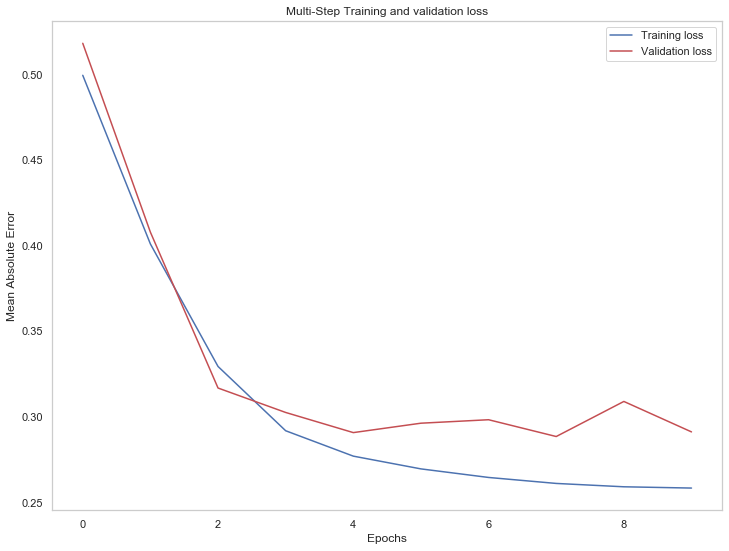

In [130]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

We make a batch of predictions for comparison.

In [131]:
for x, y in val_data_multi.take(1):
    rnn_data = []
    rnn_comp_pred = []
    for a in range(len(x)):
        rnn_data.append(y[a])
        rnn_comp_pred.append(multi_step_model.predict(x)[a])

The same RNN training and predictions process is then repeated for 48 hour and 72 hours of past history training windows.

# RNN - 48 Hour Training Window

In [132]:
long_mvms_past_history = 48
mvms_future_target = 24
mvms_STEP = 1

In [133]:
long_x_train_multi, long_y_train_multi = multivariate_data(usageDataArray, usageDataArray[:, 0], 0,
                                                 TRAIN_SPLIT, long_mvms_past_history,
                                                 mvms_future_target, mvms_STEP)
long_x_val_multi, long_y_val_multi = multivariate_data(usageDataArray, usageDataArray[:, 0],
                                             TRAIN_SPLIT, None, long_mvms_past_history,
                                             mvms_future_target, mvms_STEP)

In [134]:
print ('Single window of past history : {}'.format(long_x_train_multi[0].shape))
print ('\n Target usage to predict : {}'.format(long_y_train_multi[0].shape))

Single window of past history : (48, 4)

 Target usage to predict : (24,)


In [135]:
long_train_data_multi = tf.data.Dataset.from_tensor_slices((long_x_train_multi, long_y_train_multi))
long_train_data_multi = long_train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

long_val_data_multi = tf.data.Dataset.from_tensor_slices((long_x_val_multi, long_y_val_multi))
long_val_data_multi = long_val_data_multi.batch(BATCH_SIZE).repeat()

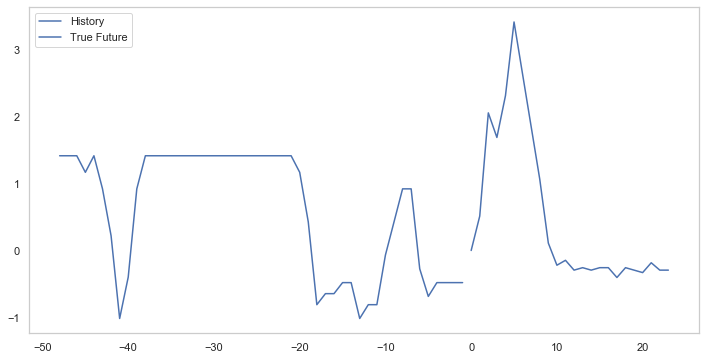

In [136]:
for x, y in long_train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [137]:
long_multi_step_model = tf.keras.models.Sequential()

long_multi_step_model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation='relu', input_shape=long_x_train_multi.shape[-2:]))
long_multi_step_model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
long_multi_step_model.add(tf.keras.layers.Dropout(rate=0.1))

long_multi_step_model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=3, activation='relu', input_shape=long_x_train_multi.shape[-2:]))
long_multi_step_model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
long_multi_step_model.add(tf.keras.layers.Dropout(rate=0.1))

long_multi_step_model.add(tf.keras.layers.LSTM(100, activation='relu',return_sequences=True))
long_multi_step_model.add(tf.keras.layers.LSTM(100, activation='relu'))

long_multi_step_model.add(tf.keras.layers.Dropout(rate=0.3))

long_multi_step_model.add(tf.keras.layers.Dense(24))


long_multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=['mean_squared_error',
                                                                                                    root_mean_squared_error])

In [138]:
for x, y in long_val_data_multi.take(1):
  print (long_multi_step_model.predict(x).shape)

(256, 24)


In [139]:
long_multi_step_history = long_multi_step_model.fit(long_train_data_multi, epochs=10,
                                          steps_per_epoch=200,
                                          validation_data=long_val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 26s 131ms/step - loss: 0.4820 - mean_squared_error: 1.0546 - root_mean_squared_error: 1.0262 - val_loss: 0.5512 - val_mean_squared_error: 1.2844 - val_root_mean_squared_error: 1.1187
Epoch 2/10
200/200 [==============================] - 20s 101ms/step - loss: 0.4040 - mean_squared_error: 0.7423 - root_mean_squared_error: 0.8566 - val_loss: 0.3775 - val_mean_squared_error: 0.5784 - val_root_mean_squared_error: 0.7528
Epoch 3/10
200/200 [==============================] - 20s 100ms/step - loss: 0.3009 - mean_squared_error: 0.4297 - root_mean_squared_error: 0.6542 - val_loss: 0.2965 - val_mean_squared_error: 0.4737 - val_root_mean_squared_error: 0.6805
Epoch 4/10
200/200 [==============================] - 20s 100ms/step - loss: 0.2647 - mean_squared_error: 0.3631 - root_mean_squared_error: 0.6017 - val_loss: 0.2851 - val_mean_squared_error: 0.4409 - val_root_mean_squared_error: 0.6558
Epoch 5/1

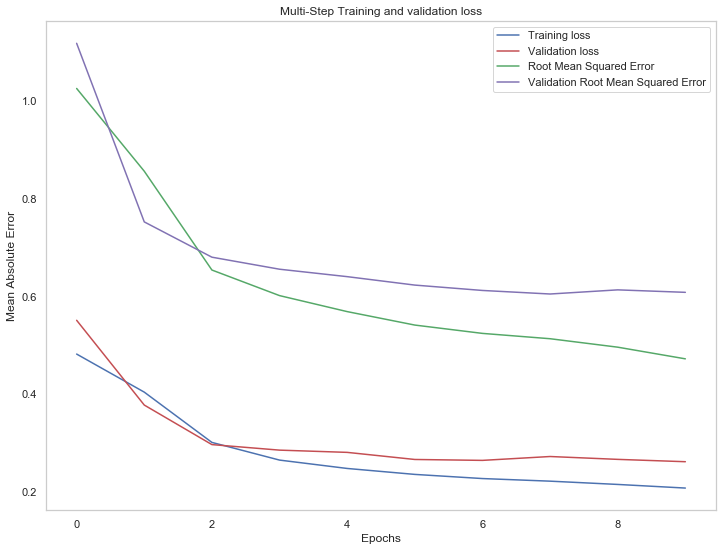

In [140]:
plot_train_history(long_multi_step_history, 'Multi-Step Training and validation loss', rmse= True)

In [141]:
long_rnn_data = []
long_rnn_comp_pred = []

for x, y in long_val_data_multi.take(1):
    for a in range(len(x)):
        long_rnn_data.append(y[a])
        long_rnn_comp_pred.append(long_multi_step_model.predict(x)[a])

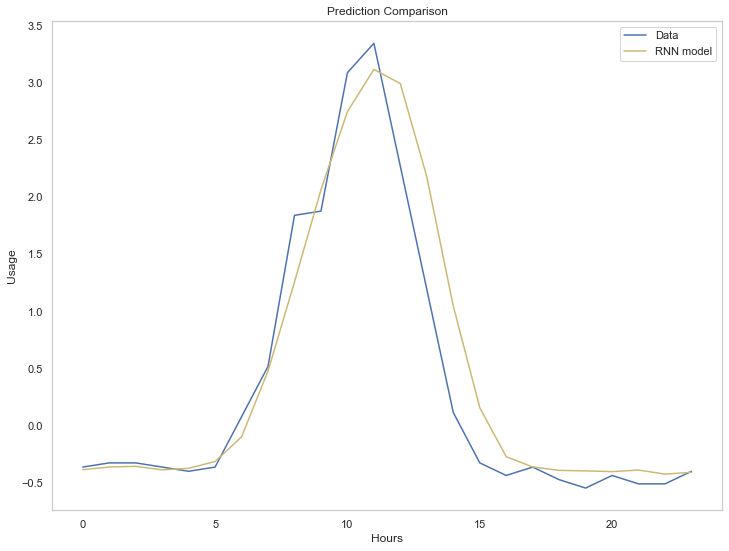

In [142]:
dates = np.arange(0,24)
    
plt.plot(dates, long_rnn_data[200], c='b', label='Data')
plt.plot(dates, long_rnn_comp_pred[200], c= 'y', label='RNN model')
    
plt.xlabel('Hours')
plt.ylabel('Usage')
plt.title('Prediction Comparison')
plt.legend()
plt.show()

# RNN - 72 Hour Training Window

In [143]:
three_day_mvms_past_history = 72
mvms_future_target = 24
mvms_STEP = 1

In [144]:
three_day_x_train_multi, three_day_y_train_multi = multivariate_data(usageDataArray, usageDataArray[:, 0], 0,
                                                 TRAIN_SPLIT, three_day_mvms_past_history,
                                                 mvms_future_target, mvms_STEP)
three_day_x_val_multi, three_day_y_val_multi = multivariate_data(usageDataArray, usageDataArray[:, 0],
                                             TRAIN_SPLIT, None, three_day_mvms_past_history,
                                             mvms_future_target, mvms_STEP)

In [145]:
print ('Single window of past history : {}'.format(three_day_x_train_multi[0].shape))
print ('\n Target usage to predict : {}'.format(three_day_y_train_multi[0].shape))

Single window of past history : (72, 4)

 Target usage to predict : (24,)


In [146]:
three_day_train_data_multi = tf.data.Dataset.from_tensor_slices((three_day_x_train_multi, three_day_y_train_multi))
three_day_train_data_multi = three_day_train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

three_day_val_data_multi = tf.data.Dataset.from_tensor_slices((three_day_x_val_multi, three_day_y_val_multi))
three_day_val_data_multi = three_day_val_data_multi.batch(BATCH_SIZE).repeat()

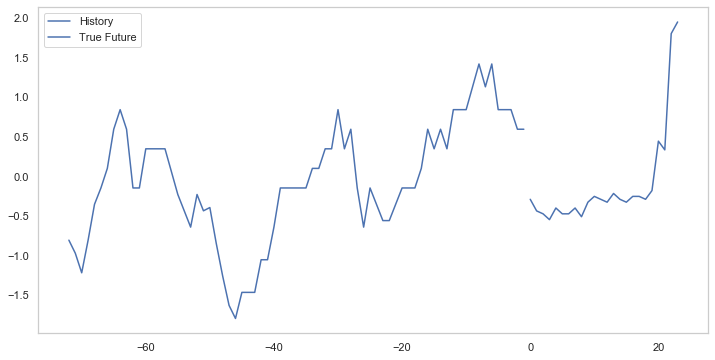

In [147]:
for x, y in three_day_train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [148]:
three_day_multi_step_model = tf.keras.models.Sequential()

three_day_multi_step_model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation='relu', input_shape=three_day_x_train_multi.shape[-2:]))
three_day_multi_step_model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
three_day_multi_step_model.add(tf.keras.layers.Dropout(rate=0.1))

three_day_multi_step_model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=3, activation='relu', input_shape=three_day_x_train_multi.shape[-2:]))
three_day_multi_step_model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
three_day_multi_step_model.add(tf.keras.layers.Dropout(rate=0.1))

three_day_multi_step_model.add(tf.keras.layers.LSTM(100, activation='relu',return_sequences=True))
three_day_multi_step_model.add(tf.keras.layers.LSTM(100, activation='relu'))

three_day_multi_step_model.add(tf.keras.layers.Dropout(rate=0.3))

three_day_multi_step_model.add(tf.keras.layers.Dense(24))


three_day_multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=['mean_squared_error',
                                                                                                    root_mean_squared_error])

In [149]:
for x, y in three_day_val_data_multi.take(1):
  print (three_day_multi_step_model.predict(x).shape)

(256, 24)


In [150]:
three_day_multi_step_history = three_day_multi_step_model.fit(three_day_train_data_multi, epochs=10,
                                          steps_per_epoch=200,
                                          validation_data=three_day_val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 54s 270ms/step - loss: 0.4772 - mean_squared_error: 1.0157 - root_mean_squared_error: 1.0061 - val_loss: 0.5230 - val_mean_squared_error: 1.1555 - val_root_mean_squared_error: 1.0651
Epoch 2/10
200/200 [==============================] - 55s 275ms/step - loss: 0.3496 - mean_squared_error: 0.5391 - root_mean_squared_error: 0.7303 - val_loss: 0.3536 - val_mean_squared_error: 0.5778 - val_root_mean_squared_error: 0.7511
Epoch 3/10
200/200 [==============================] - 53s 263ms/step - loss: 0.2810 - mean_squared_error: 0.3935 - root_mean_squared_error: 0.6261 - val_loss: 0.3084 - val_mean_squared_error: 0.5029 - val_root_mean_squared_error: 0.6984
Epoch 4/10
200/200 [==============================] - 53s 263ms/step - loss: 0.2562 - mean_squared_error: 0.3411 - root_mean_squared_error: 0.5832 - val_loss: 0.2945 - val_mean_squared_error: 0.4051 - val_root_mean_squared_error: 0.6256
Epoch 5/1

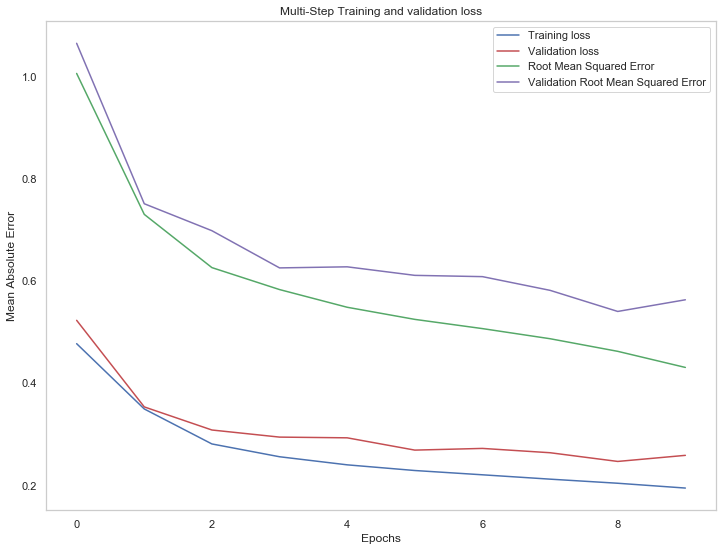

In [151]:
plot_train_history(three_day_multi_step_history, 'Multi-Step Training and validation loss', rmse= True)

In [152]:
three_day_rnn_data = []
three_day_rnn_comp_pred = []

for x, y in three_day_val_data_multi.take(1):
    for a in range(len(x)):
        three_day_rnn_data.append(y[a])
        three_day_rnn_comp_pred.append(three_day_multi_step_model.predict(x)[a])

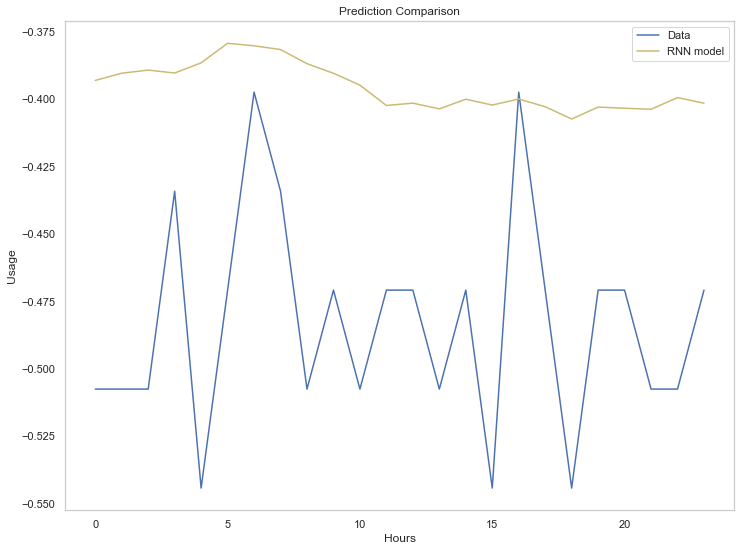

In [153]:
dates = np.arange(0,24)
    
plt.plot(dates, three_day_rnn_data[200], c='b', label='Data')
plt.plot(dates, three_day_rnn_comp_pred[200], c= 'y', label='RNN model')
    
plt.xlabel('Hours')
plt.ylabel('Usage')
plt.title('Prediction Comparison')
plt.legend()
plt.show()

# Evaluation

The following functions take in 24 hour periods of data and evaluate predictions made over them for three different metrics.

In [154]:
def twentyfour_hour_mae(y_pred, y_true):
    mae = []
    for a in range(len(y_pred)):
        mae.append(mean_absolute_error(y_pred[a],y_true[a]))
    
    return (np.array(mae))

In [155]:
def twentyfour_hour_rmse(y_pred, y_true):
    rmse = []
    for a in range(len(y_pred)):
        rmse.append(simple_rmse(y_pred[a],y_true[a]))
    
    return (np.array(rmse))

In [156]:
def twentyfour_hour_r_squared(y_pred, y_true):
    r_squared = []
    for a in range(len(y_pred)):
        r_squared.append(get_r_squared(y_pred[a],y_true[a]))
    
    return (np.array(r_squared))

In [157]:
def smape(actual, forecasted):
    return 1/len(actual) * np.sum(2 * np.abs(forecasted - actual) / (np.abs(actual) + np.abs(forecasted)))

In [158]:
def twentyfour_hour_smape(y_pred, y_true):
    smape_arr = []
    for a in range(len(y_pred)):
        smape_arr.append(smape(y_pred[a],y_true[a]))
    
    return (np.array(smape_arr))

In [159]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def simple_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

We then calculate the error of each model across their batches of predictions.

In [160]:
rnn_batch_mae = (twentyfour_hour_mae(rnn_comp_pred,long_rnn_data))
rnn_batch_rmse = (twentyfour_hour_rmse(rnn_comp_pred,long_rnn_data))
rnn_batch_smape = (twentyfour_hour_smape(long_rnn_data,rnn_comp_pred))

two_day_rnn_batch_mae = (twentyfour_hour_mae(long_rnn_comp_pred,long_rnn_data))
two_day_rnn_batch_rmse = (twentyfour_hour_rmse(long_rnn_comp_pred,long_rnn_data))
two_day_rnn_batch_smape = (twentyfour_hour_smape(long_rnn_data,long_rnn_comp_pred))

three_day_rnn_batch_mae = (twentyfour_hour_mae(three_day_rnn_comp_pred,long_rnn_data))
three_day_rnn_batch_rmse = (twentyfour_hour_rmse(three_day_rnn_comp_pred,long_rnn_data))
three_day_rnn_batch_smape = (twentyfour_hour_smape(three_day_rnn_data,long_rnn_comp_pred))

svm_batch_mae = (twentyfour_hour_mae(svm_comp_pred,long_rnn_data))
svm_batch_rmse = (twentyfour_hour_rmse(svm_comp_pred,long_rnn_data))
svm_batch_smape = (twentyfour_hour_smape(long_rnn_data,svm_comp_pred))

We plot the cumulative error for models across their prediction batches

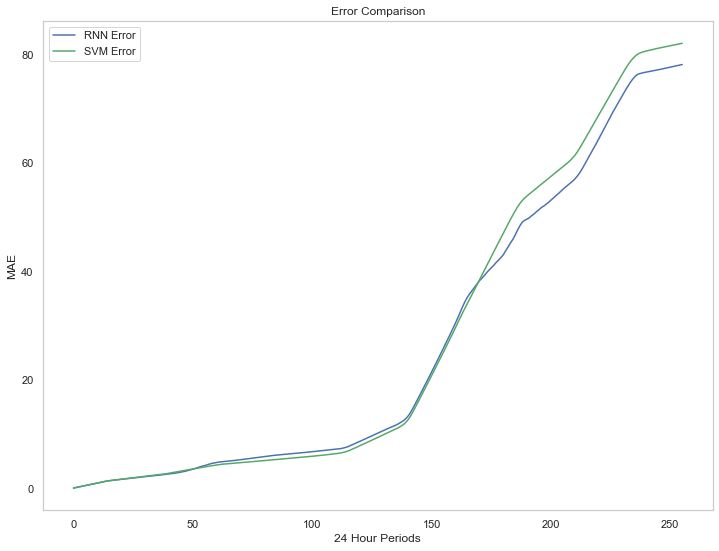

In [161]:
dates = np.arange(0,256)

plt.plot(dates, rnn_batch_mae.cumsum(), color = 'b', label='RNN Error')
plt.plot(dates, svm_batch_mae.cumsum(), color = 'g', label='SVM Error')

plt.xlabel('24 Hour Periods')
plt.ylabel('MAE')
plt.title('Error Comparison')
plt.legend()
plt.show()

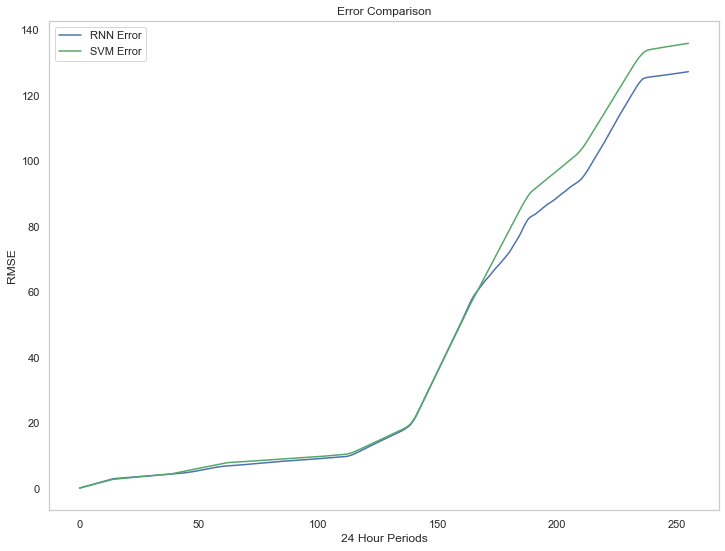

In [162]:
dates = np.arange(0,256)

plt.plot(dates, rnn_batch_rmse.cumsum(), color = 'b', label='RNN Error')
plt.plot(dates, svm_batch_rmse.cumsum(), color = 'g', label='SVM Error')

plt.xlabel('24 Hour Periods')
plt.ylabel('RMSE')
plt.title('Error Comparison')
plt.legend()
plt.show()

We then collate and graph the results of the error across each different model

In [163]:
svmBars = [np.mean(svm_batch_mae), np.mean(svm_batch_rmse)]
rnnBars = [np.mean(two_day_rnn_batch_mae), np.mean(two_day_rnn_batch_rmse)]

groupedBarErrorData = np.array([["SVM", "MAE", np.mean(svm_batch_mae)],
                                ["SVM","RMSE", np.mean(svm_batch_rmse)], 
                                ["SVM", "SMAPE", np.mean(svm_batch_smape)], 
                                ["24H-RNN", "MAE", np.mean(rnn_batch_mae)],
                                ["24H-RNN", "RMSE", np.mean(rnn_batch_rmse)],
                                ["24H-RNN", "SMAPE", np.mean(rnn_batch_smape)]
                               ])

rnnGroupedBarErrorData = np.array([["24H-RNN", "MAE", np.mean(rnn_batch_mae)],
                                ["24H-RNN", "RMSE", np.mean(rnn_batch_rmse)],
                                ["24H-RNN", "SMAPE", np.mean(rnn_batch_smape)],
                                ["48H-RNN", "MAE", np.mean(two_day_rnn_batch_mae)],
                                ["48H-RNN", "RMSE", np.mean(two_day_rnn_batch_rmse)],
                                ["48H-RNN", "SMAPE", np.mean(two_day_rnn_batch_smape)],
                                ["72H-RNN", "MAE", np.mean(three_day_rnn_batch_mae)],
                                ["72H-RNN", "RMSE", np.mean(three_day_rnn_batch_rmse)],
                                ["72H-RNN", "SMAPE", np.mean(three_day_rnn_batch_smape)]])

groupedBarErrorDataFrame = pd.DataFrame(groupedBarErrorData, columns=["Model", "Metric", "Accuracy"])
rnnGroupedBarErrorDataFrame = pd.DataFrame(rnnGroupedBarErrorData, columns=["Model", "Metric", "Accuracy"])

groupedBarErrorDataFrame.head(10)

,Model,Metric,Accuracy
0,SVM,MAE,0.32064052575210694
1,SVM,RMSE,0.531321384324828
2,SVM,SMAPE,0.44058607504374914
3,24H-RNN,MAE,0.3053653086324255
4,24H-RNN,RMSE,0.49742672340562194
5,24H-RNN,SMAPE,0.428714979185556


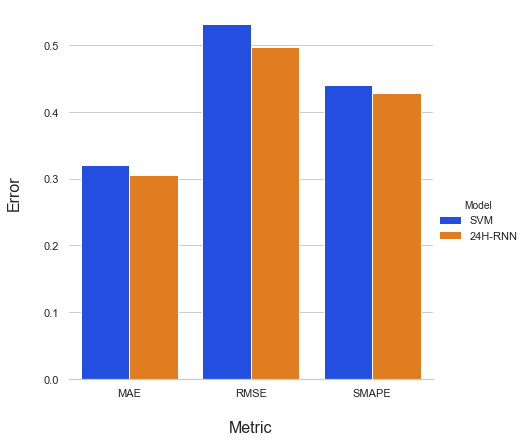

In [164]:
import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="Metric", y="Accuracy", hue="Model", data=groupedBarErrorDataFrame,
                height=6, kind="bar", palette="bright")
g.despine(left=True)
g.set_ylabels("Error\n", fontsize = 16)
g.set_xlabels("\nMetric", fontsize = 16)

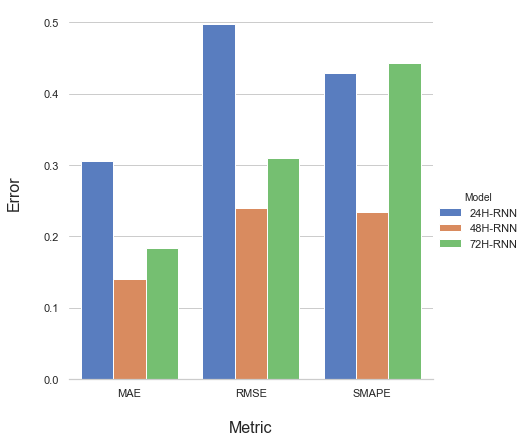

In [165]:
import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="Metric", y="Accuracy", hue="Model", data=rnnGroupedBarErrorDataFrame,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Error\n", fontsize = 16)
g.set_xlabels("\nMetric", fontsize = 16)